In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.interpolate import CubicSpline
from itertools import product
from sklearn.metrics import r2_score
import csv
from vmd import VMD

In [54]:
# adjusted R-squared
def r2_score_adjusted(y, y_pred, featurecount):
    n = len(y)
    return 1 - (1-r2_score(y, y_pred)) * (n-1)/(n-featurecount-1)

# AIC
def calculate_aic(y, y_pred, k):
    sse = np.sum((y - y_pred) ** 2)
    n = len(y)
    aic = n * np.log(sse / n) + 2 * k
    return aic

# BIC
def calculate_bic(y, y_pred, k):
    sse = np.sum((y - y_pred) ** 2)
    n = len(y)
    bic = n * np.log(sse / n) + k * np.log(n)
    return bic

# импорт временного ряда

In [55]:
index = list()
TS = list()
Trend = list()

s = pd.read_csv(f".\Components\\s10.csv", decimal=',')
n = pd.read_csv(f".\Components\\n1.csv", decimal=',')
Season = pd.DataFrame(s, dtype=float)
Season = Season["Value"]
Noise = pd.DataFrame(n, dtype=float)
Noise = Noise["Value"]
freg = np.fft.rfftfreq(len(Noise))
Noise = np.abs(np.fft.rfft(Noise))

for i in range(1,8):
    data = pd.read_csv(f".\Cases\\t{i}_n1_s10.csv", decimal=',')
    t = pd.read_csv(f".\Components\\t{i}.csv", decimal=',')

    df = pd.DataFrame(data, dtype=float)
    trend = pd.DataFrame(t, dtype=float)

    index.append(df.index)
    TS.append(df.values) 
    Trend.append(trend["Value"])

# тестовый анализ

In [56]:
alpha = 1000
init = 1
DC = True
K = 5
tau = 0            #BY DEFAULT  
tol = 1e-6         #BY DEFAULT

u, u_hat, omega = VMD(TS[0], alpha, tau, K, DC, init, tol)

featurecount = 6

In [58]:
imf_freg = np.abs(np.fft.rfft(u[4].T))
len(imf_freg)

751

Text(0.5, 0, 'X')

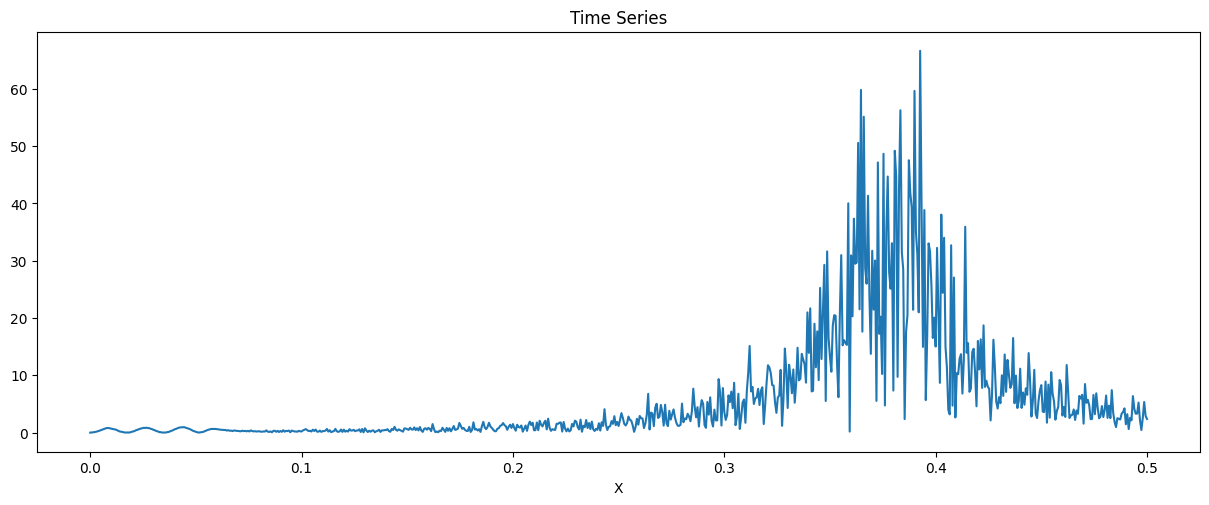

In [59]:
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)
plt.plot(freg, imf_freg)
plt.title('Time Series')
plt.xlabel('X')

In [60]:
r2_score(imf_freg, Noise)

-10.443648038281573

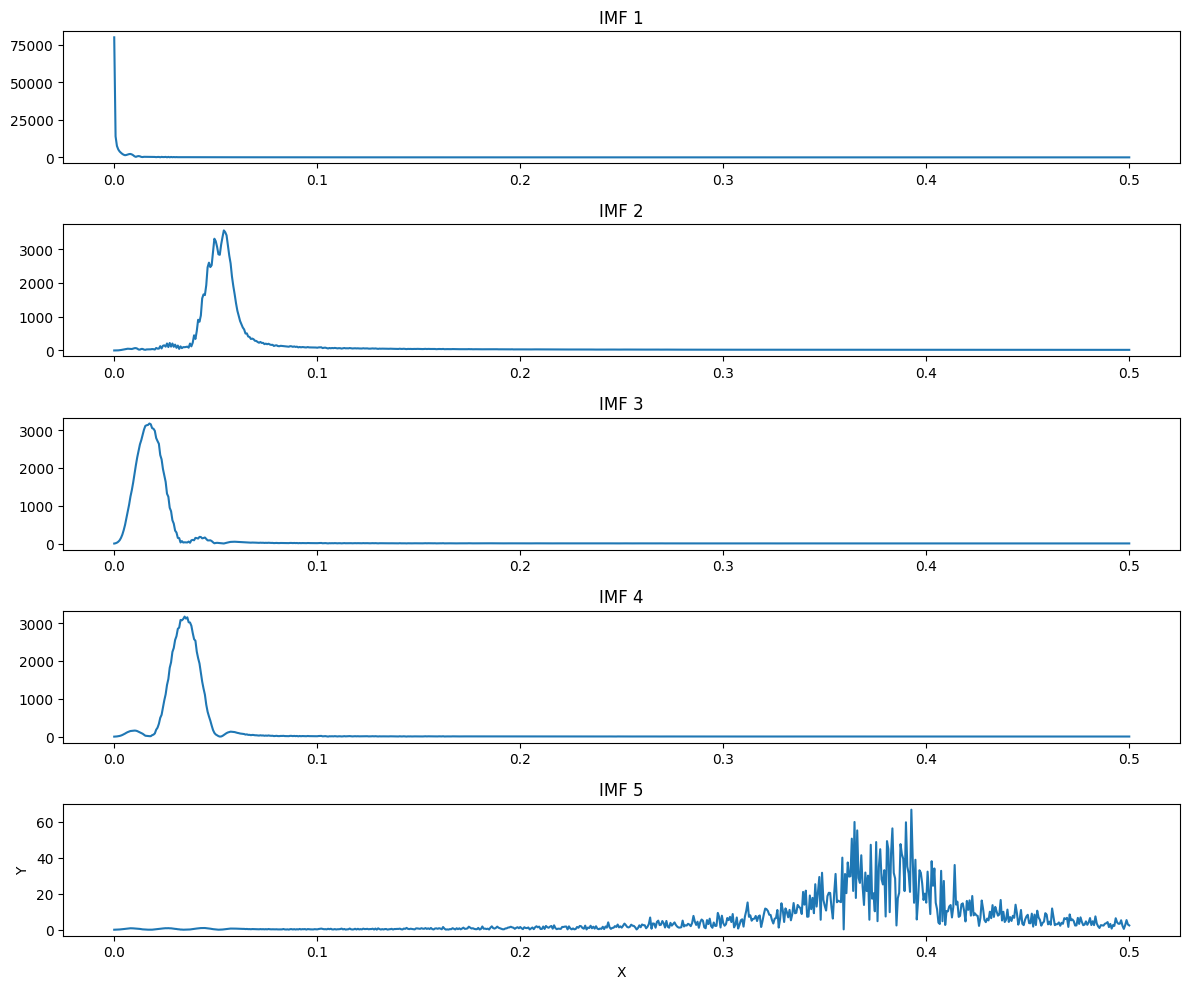

In [62]:
# plt.figure(figsize=(15,12))
# plt.subplot(2,1,1)
# plt.plot(index[0], TS[0])

fig, axs = plt.subplots(figsize=(12,10), nrows=K)

# axs[0].set(xlabel = 'date', ylabel='C')
# plt.subplot(2,2,1)
for i in range(K):
    axs[i].plot(freg, np.abs(np.fft.rfft(u[i].T)))
    axs[i].set_title(f'IMF {i+1}')

plt.xlabel('X')
plt.ylabel('Y')
# plt.legend(['Оригинальный сигнал', 'Нижняя огибающая', 'Верхняя огибающая', 'Средняя огибающих'])

plt.tight_layout()

# декомпозиция временного ряда

In [64]:
alpha = (0, 500, 1000, 5000, 10000, 20000)
init = (0, 1, 2)
DC = (False, True)
K = (3, 5, 7)

tau = 0            #BY DEFAULT  
tol = 1e-6         #BY DEFAULT

featurecount = 6

In [65]:
best_metriks = list()

best_r2_params = list()
best_r2_adj_params = list()
best_aic_params = list()
best_bic_params = list()

# для всех лчм
for ts_i in range(len(TS)):
    best_metriks.append({"Time Series": f"TS{ts_i+1}", "R2": -np.inf, "R2_Adj": -np.inf, "AIC" : np.inf, "BIC": np.inf})

    best_r2_params.append({"Time Series": f"TS{ts_i+1}", "Metric": "R2", "alpha": 0, "tau": tau, "K": 3, "DC": False, "init": 0, "tol": tol, "Noise IMFs": "3"}) 
    best_r2_adj_params.append({"Time Series": f"TS{ts_i+1}", "Metric": "R2_Adj", "alpha": 0, "tau": tau, "K": 3, "DC": False, "init": 0, "tol": tol, "Noise IMFs": "3"}) 
    best_aic_params.append({"Time Series": f"TS{ts_i+1}", "Metric": "AIC", "alpha": 0, "tau": tau, "K": 3, "DC": False, "init": 0, "tol": tol, "Noise IMFs": "3"}) 
    best_bic_params.append({"Time Series": f"TS{ts_i+1}", "Metric": "BIC", "alpha": 0, "tau": tau, "K": 3, "DC": False, "init": 0, "tol": tol, "Noise IMFs": "3"}) 
    
    # для всех наборов параметров
    for params_set in list(product(alpha, K, DC, init)):
        u, u_hat, omega = VMD(TS[ts_i], params_set[0], tau, params_set[1], params_set[2], params_set[3], tol)
        # best_params = [{"Time Series": f"t{ts_i+1}" ,"alpha": params_set[0], "tau": tau, "K": params_set[1], "DC": params_set[2], "init": params_set[3], "tol": tol}]
        
        k_i = params_set[1]
        for i_imfs in range(k_i-2, k_i):

            sum_of_imfs = 0
            for j in range(i_imfs, k_i):
                sum_of_imfs += u[j].T
            
            imf_freg = np.abs(np.fft.rfft(sum_of_imfs))
            r2 = r2_score(Noise, imf_freg)
            r2_adj = r2_score_adjusted(Noise, imf_freg, featurecount)
            aic = calculate_aic(Noise, imf_freg, featurecount)
            bic = calculate_bic(Noise, imf_freg, featurecount)

            if (r2 > best_metriks[ts_i]["R2"]):
                best_metriks[ts_i]["R2"] = r2

                best_r2_params[ts_i]["alpha"] = params_set[0]
                best_r2_params[ts_i]["K"] = params_set[1]
                best_r2_params[ts_i]["DC"] = params_set[2]
                best_r2_params[ts_i]["init"] = params_set[3]
                best_r2_params[ts_i]["Noise IMFs"] = f'2 - {i_imfs+1}'

            if (r2_adj > best_metriks[ts_i]["R2_Adj"]):
                best_metriks[ts_i]["R2_Adj"] = r2_adj

                best_r2_adj_params[ts_i]["alpha"] = params_set[0]
                best_r2_adj_params[ts_i]["K"] = params_set[1]
                best_r2_adj_params[ts_i]["DC"] = params_set[2]
                best_r2_adj_params[ts_i]["init"] = params_set[3]
                best_r2_adj_params[ts_i]["Noise IMFs"] = f'2 - {i_imfs+1}'


            if (aic < best_metriks[ts_i]["AIC"]):
                best_metriks[ts_i]["AIC"] = aic

                best_aic_params[ts_i]["alpha"] = params_set[0]
                best_aic_params[ts_i]["K"] = params_set[1]
                best_aic_params[ts_i]["DC"] = params_set[2]
                best_aic_params[ts_i]["init"] = params_set[3]
                best_aic_params[ts_i]["Noise IMFs"] = f'2 - {i_imfs+1}'

            if (bic < best_metriks[ts_i]["BIC"]):
                best_metriks[ts_i]["BIC"] = bic

                best_bic_params[ts_i]["alpha"] = params_set[0]
                best_bic_params[ts_i]["K"] = params_set[1]
                best_bic_params[ts_i]["DC"] = params_set[2]
                best_bic_params[ts_i]["init"] = params_set[3]
                best_bic_params[ts_i]["Noise IMFs"] = f'2 - {i_imfs+1}'


c:\Users\George\VS Code Projects\TS Generator\про лчм\vmd.py:67: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(freqs[T//2:T],(abs(u_hat_plus[n+1, T//2:T, k])**2))/np.sum(abs(u_hat_plus[n+1,T//2:T,k])**2)
c:\Users\George\VS Code Projects\TS Generator\про лчм\vmd.py:64: RuntimeWarning: invalid value encountered in divide
  return (f_hat_plus - sum_uk - lambda_hat[n,:]/2)/(1.+Alpha[k]*(freqs - omega_plus[n,k])**2)
c:\Users\George\VS Code Projects\TS Generator\про лчм\vmd.py:67: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(freqs[T//2:T],(abs(u_hat_plus[n+1, T//2:T, k])**2))/np.sum(abs(u_hat_plus[n+1,T//2:T,k])**2)
c:\Users\George\VS Code Projects\TS Generator\про лчм\vmd.py:64: RuntimeWarning: invalid value encountered in divide
  return (f_hat_plus - sum_uk - lambda_hat[n,:]/2)/(1.+Alpha[k]*(freqs - omega_plus[n,k])**2)
c:\Users\George\VS Code Projects\TS Generator\про лчм\vmd.py:67: RuntimeWarning: invalid value encountered in sc

In [66]:
for ts_i in range(len(TS)):
    # для всех наборов параметров
    for params_set in list(product(alpha, K, DC, init)):
        u, u_hat, omega = VMD(TS[ts_i], params_set[0], tau, params_set[1], params_set[2], params_set[3], tol)
        # best_params = [{"Time Series": f"t{ts_i+1}" ,"alpha": params_set[0], "tau": tau, "K": params_set[1], "DC": params_set[2], "init": params_set[3], "tol": tol}]
        
        k_i = params_set[1]
        for i_imfs in range(k_i):

            sum_of_imfs = 0
            for j in range(i_imfs+1):
                sum_of_imfs += u[j].T
            residual = TS[ts_i].T[0] - sum_of_imfs

            imf_freg = np.abs(np.fft.rfft(residual))
            r2 = r2_score(Noise, imf_freg)
            r2_adj = r2_score_adjusted(Noise, imf_freg, featurecount)
            aic = calculate_aic(Noise, imf_freg, featurecount)
            bic = calculate_bic(Noise, imf_freg, featurecount)

            if (r2 > best_metriks[ts_i]["R2"]):
                best_metriks[ts_i]["R2"] = r2

                best_r2_params[ts_i]["alpha"] = params_set[0]
                best_r2_params[ts_i]["K"] = params_set[1]
                best_r2_params[ts_i]["DC"] = params_set[2]
                best_r2_params[ts_i]["init"] = params_set[3]
                best_r2_params[ts_i]["Noise IMFs"] = f'F(t) - IMFs[1-{i_imfs+1}]'

            if (r2_adj > best_metriks[ts_i]["R2_Adj"]):
                best_metriks[ts_i]["R2_Adj"] = r2_adj

                best_r2_adj_params[ts_i]["alpha"] = params_set[0]
                best_r2_adj_params[ts_i]["K"] = params_set[1]
                best_r2_adj_params[ts_i]["DC"] = params_set[2]
                best_r2_adj_params[ts_i]["init"] = params_set[3]
                best_r2_adj_params[ts_i]["Noise IMFs"] = f'F(t) - IMFs[1-{i_imfs+1}]'


            if (aic < best_metriks[ts_i]["AIC"]):
                best_metriks[ts_i]["AIC"] = aic

                best_aic_params[ts_i]["alpha"] = params_set[0]
                best_aic_params[ts_i]["K"] = params_set[1]
                best_aic_params[ts_i]["DC"] = params_set[2]
                best_aic_params[ts_i]["init"] = params_set[3]
                best_aic_params[ts_i]["Noise IMFs"] = f'F(t) - IMFs[1-{i_imfs+1}]'

            if (bic < best_metriks[ts_i]["BIC"]):
                best_metriks[ts_i]["BIC"] = bic

                best_bic_params[ts_i]["alpha"] = params_set[0]
                best_bic_params[ts_i]["K"] = params_set[1]
                best_bic_params[ts_i]["DC"] = params_set[2]
                best_bic_params[ts_i]["init"] = params_set[3]
                best_bic_params[ts_i]["Noise IMFs"] = f'F(t) - IMFs[1-{i_imfs+1}]'

c:\Users\George\VS Code Projects\TS Generator\про лчм\vmd.py:67: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(freqs[T//2:T],(abs(u_hat_plus[n+1, T//2:T, k])**2))/np.sum(abs(u_hat_plus[n+1,T//2:T,k])**2)
c:\Users\George\VS Code Projects\TS Generator\про лчм\vmd.py:64: RuntimeWarning: invalid value encountered in divide
  return (f_hat_plus - sum_uk - lambda_hat[n,:]/2)/(1.+Alpha[k]*(freqs - omega_plus[n,k])**2)
c:\Users\George\VS Code Projects\TS Generator\про лчм\vmd.py:67: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(freqs[T//2:T],(abs(u_hat_plus[n+1, T//2:T, k])**2))/np.sum(abs(u_hat_plus[n+1,T//2:T,k])**2)
c:\Users\George\VS Code Projects\TS Generator\про лчм\vmd.py:64: RuntimeWarning: invalid value encountered in divide
  return (f_hat_plus - sum_uk - lambda_hat[n,:]/2)/(1.+Alpha[k]*(freqs - omega_plus[n,k])**2)
c:\Users\George\VS Code Projects\TS Generator\про лчм\vmd.py:67: RuntimeWarning: invalid value encountered in sc

# метрики точности и параметры с выводом

In [67]:
filename=".\Output\\Best_Metriks-Noise-freg.csv"

fields = best_metriks[0].keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row
    for ts_i in range(len(TS)):
        writer.writerows([best_metriks[ts_i]])  # Write data rows

In [68]:
filename=".\Output\\Parameters-Noise-freg.csv"

fields = best_r2_params[0].keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row
    for ts_i in range(len(TS)):
        writer.writerows([best_r2_params[ts_i]])  # Write data rows
        writer.writerows([best_r2_adj_params[ts_i]])  # Write data rows
        writer.writerows([best_aic_params[ts_i]])  # Write data rows
        writer.writerows([best_bic_params[ts_i]])  # Write data rows

